Определённая кодировка: windows-1251
Порог поддержки: 1.0%; время: 2.1131 сек; найдено наборов: 261
Порог поддержки: 3.0%; время: 0.3803 сек; найдено наборов: 55
Порог поддержки: 5.0%; время: 0.1718 сек; найдено наборов: 28
Порог поддержки: 10.0%; время: 0.0273 сек; найдено наборов: 7
Порог поддержки: 15.0%; время: 0.0220 сек; найдено наборов: 5


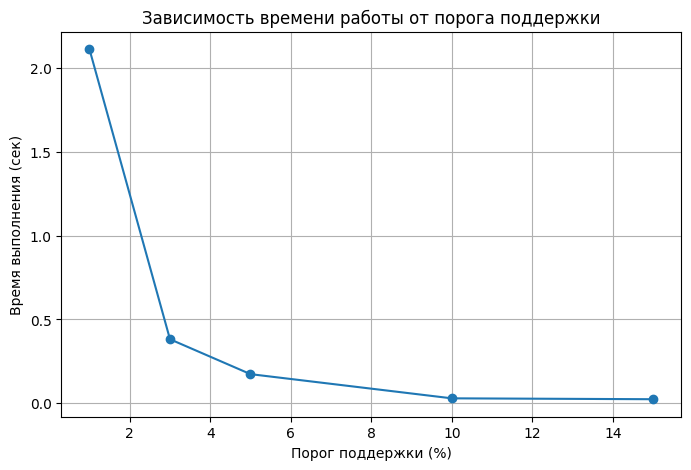

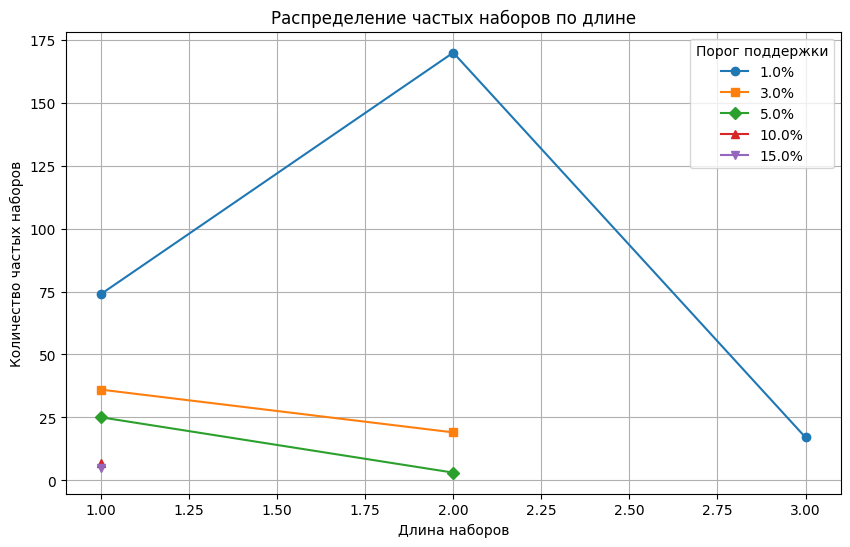

In [ ]:
# Установка модуля chardet (если он ещё не установлен)
!pip install chardet

import csv
import time
import itertools
import collections
import matplotlib.pyplot as plt
import chardet

# Функция для определения кодировки файла с использованием chardet
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        raw_data = f.read(10000)  # читаем первые 10К байт
        result = chardet.detect(raw_data)
        encoding = result['encoding']
        print("Определённая кодировка:", encoding)
        return encoding

# Функция для загрузки корзин из CSV-файла с использованием определённой кодировки
def load_baskets(file_path):
    encoding = detect_encoding(file_path)
    baskets = []
    with open(file_path, 'r', encoding=encoding) as f:
        reader = csv.reader(f)
        for row in reader:
            # Убираем лишние пробелы, исключая пустые строки
            basket = set(item.strip() for item in row if item.strip() != '')
            if basket:
                baskets.append(basket)
    return baskets

# Функция для вычисления поддержки набора
def support(itemset, baskets):
    count = sum(1 for basket in baskets if itemset.issubset(basket))
    return count / len(baskets)

# Реализация алгоритма Apriori для поиска частых наборов
def apriori(baskets, min_support):
    frequent_itemsets = {}
    n_baskets = len(baskets)

    # Первый проход: частые 1-элементные наборы
    item_counts = collections.Counter()
    for basket in baskets:
        for item in basket:
            item_counts[frozenset([item])] += 1

    L1 = {itemset: count / n_baskets for itemset, count in item_counts.items() if count / n_baskets >= min_support}
    frequent_itemsets.update(L1)
    current_L = set(L1.keys())
    k = 2

    # Генерация кандидатов и подсчёт их поддержки для наборов длины k
    while current_L:
        candidates = set()
        current_L_list = list(current_L)
        for i in range(len(current_L_list)):
            for j in range(i + 1, len(current_L_list)):
                union_set = current_L_list[i] | current_L_list[j]
                if len(union_set) == k:
                    # Проверка, что все (k-1)-подмножества кандидата являются частыми
                    subsets = itertools.combinations(union_set, k - 1)
                    if all(frozenset(subset) in current_L for subset in subsets):
                        candidates.add(frozenset(union_set))

        candidate_counts = collections.Counter()
        for basket in baskets:
            for candidate in candidates:
                if candidate.issubset(basket):
                    candidate_counts[candidate] += 1

        Lk = {itemset: count / n_baskets for itemset, count in candidate_counts.items() if count / n_baskets >= min_support}
        if not Lk:
            break
        frequent_itemsets.update(Lk)
        current_L = set(Lk.keys())
        k += 1

    return frequent_itemsets

# Функция для сортировки найденных наборов:
# order='support' – по убыванию поддержки, order='lex' – лексикографически
def sort_itemsets(frequent_itemsets, order='support'):
    if order == 'support':
        sorted_itemsets = sorted(frequent_itemsets.items(), key=lambda x: (-x[1], sorted(x[0])))
    elif order == 'lex':
        sorted_itemsets = sorted(frequent_itemsets.items(), key=lambda x: (sorted(x[0]), -x[1]))
    else:
        sorted_itemsets = list(frequent_itemsets.items())
    return sorted_itemsets

# Проведение экспериментов для различных порогов поддержки
def experiment(baskets, support_thresholds, sort_order='support'):
    times = []
    itemset_lengths = {}  # для каждого порога: {длина набора: количество наборов}

    for thresh in support_thresholds:
        start_time = time.time()
        freq_itemsets = apriori(baskets, thresh)
        elapsed = time.time() - start_time
        times.append(elapsed)

        # Подсчёт количества наборов по их длине
        length_count = collections.Counter(len(itemset) for itemset in freq_itemsets.keys())
        itemset_lengths[thresh] = dict(length_count)

        # Сортировка результатов и вывод информации
        sorted_results = sort_itemsets(freq_itemsets, order=sort_order)
        print(f"Порог поддержки: {thresh*100:.1f}%; время: {elapsed:.4f} сек; найдено наборов: {len(sorted_results)}")

    return times, itemset_lengths

# Основной блок выполнения кода
file_path = '/content/BAZA/baskets.csv'  # укажите путь к вашему файлу
baskets = load_baskets(file_path)

# Пороговые значения поддержки (в долях)
support_thresholds = [0.01, 0.03, 0.05, 0.10, 0.15]

# Проведение экспериментов с сортировкой по поддержке
times, itemset_lengths = experiment(baskets, support_thresholds, sort_order='support')

# Визуализация зависимости времени выполнения от порога поддержки
plt.figure(figsize=(8, 5))
plt.plot([s * 100 for s in support_thresholds], times, marker='o')
plt.xlabel("Порог поддержки (%)")
plt.ylabel("Время выполнения (сек)")
plt.title("Зависимость времени работы от порога поддержки")
plt.grid(True)
plt.savefig("runtime_vs_support.png")
plt.show()

# Визуализация распределения частых наборов по длине
plt.figure(figsize=(10, 6))
markers = ['o', 's', 'D', '^', 'v']
for i, thresh in enumerate(support_thresholds):
    lengths = sorted(itemset_lengths[thresh].keys())
    counts = [itemset_lengths[thresh].get(l, 0) for l in lengths]
    plt.plot(lengths, counts, marker=markers[i % len(markers)], label=f'{thresh*100:.1f}%')
plt.xlabel("Длина наборов")
plt.ylabel("Количество частых наборов")
plt.title("Распределение частых наборов по длине")
plt.legend(title="Порог поддержки")
plt.grid(True)
plt.savefig("itemset_length_distribution.png")
plt.show()
